In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session




/kaggle/input/data_stocks.csv


In [5]:
import pandas as pd
import numpy as np
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [6]:
path = "../input/data_stocks.csv"
data = pd.read_csv(path)

In [7]:
data.replace([np.inf, -np.inf], np.nan)
data.dropna(inplace=True)
print("Number of Records in input data : ",len(data["DATE"]))

Number of Records in input data :  41266


In [8]:
data.head(5)

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,1491226200,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.52,...,84.370,119.035,44.40,39.88,82.03,7.36,50.22,63.86,122.000,53.350
1,1491226260,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.48,...,84.370,119.035,44.11,39.88,82.03,7.38,50.22,63.74,121.770,53.350
2,1491226320,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.93,...,84.585,119.260,44.09,39.98,82.02,7.36,50.12,63.75,121.700,53.365
3,1491226380,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.44,...,84.460,119.260,44.25,39.99,82.02,7.35,50.16,63.88,121.700,53.380
4,1491226440,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.60,...,84.470,119.610,44.11,39.96,82.03,7.36,50.20,63.91,121.695,53.240


In [9]:
#Stock analysis of NASDAQ.AAPL
stockname="NASDAQ.AAPL"
from datetime import datetime
date=pd.date_range("2000-01-01", periods=100,freq='B').to_pydatetime().tolist()
date=pd.DataFrame(date,columns=["DATE"])
stock=pd.DataFrame()
stock=pd.DataFrame(data[stockname][41166:41266])
date=date.reset_index(drop=True)
stock=stock.reset_index(drop=True)
aapl=pd.concat([date,stock],axis=1)

In [10]:
aapl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE         100 non-null    datetime64[ns]
 1   NASDAQ.AAPL  100 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 KB


In [11]:
aapl.DATE = pd.to_datetime(aapl.DATE)
aapl.set_index('DATE', inplace=True)
print(aapl.head(5))
print(aapl.tail(5))

            NASDAQ.AAPL
DATE                   
2000-01-03     163.8000
2000-01-04     163.8075
2000-01-05     163.8500
2000-01-06     163.8400
2000-01-07     163.8200
            NASDAQ.AAPL
DATE                   
2000-05-15       164.11
2000-05-16       164.12
2000-05-17       164.01
2000-05-18       163.88
2000-05-19       163.98


Text(0.5, 0, 'Year')

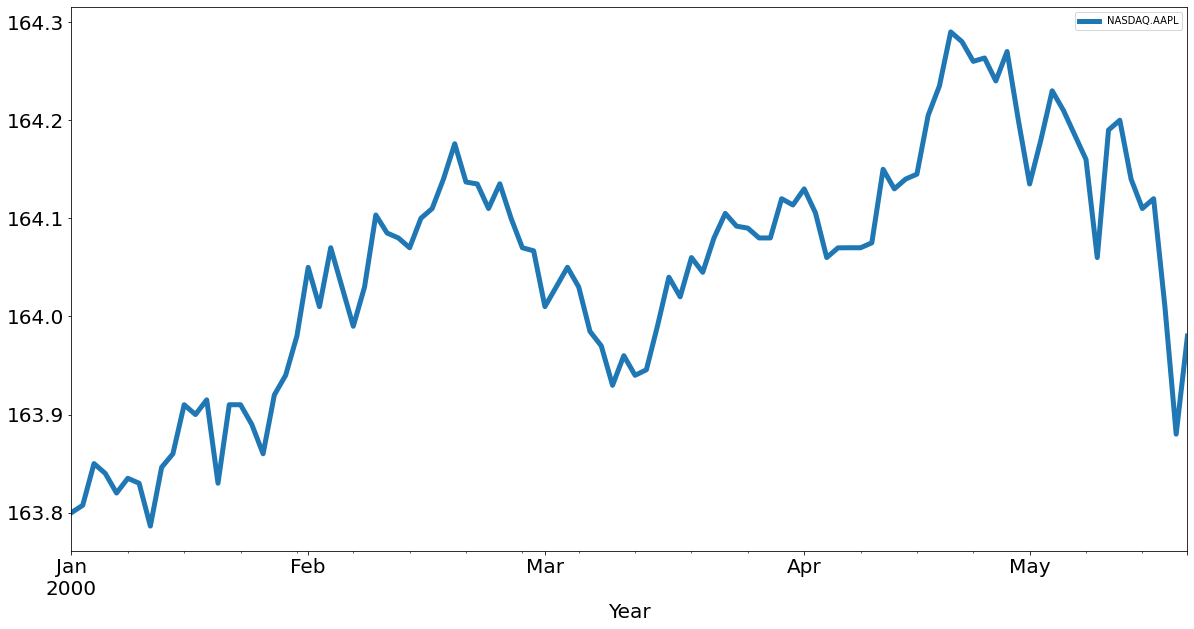

In [12]:
aapl.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

In [13]:
aapl.describe().T

,count,mean,std,min,25%,50%,75%,max
NASDAQ.AAPL,100.0,164.04984,0.123607,163.7863,163.9675,164.07,164.135,164.29


Text(0.5, 0, 'Year')

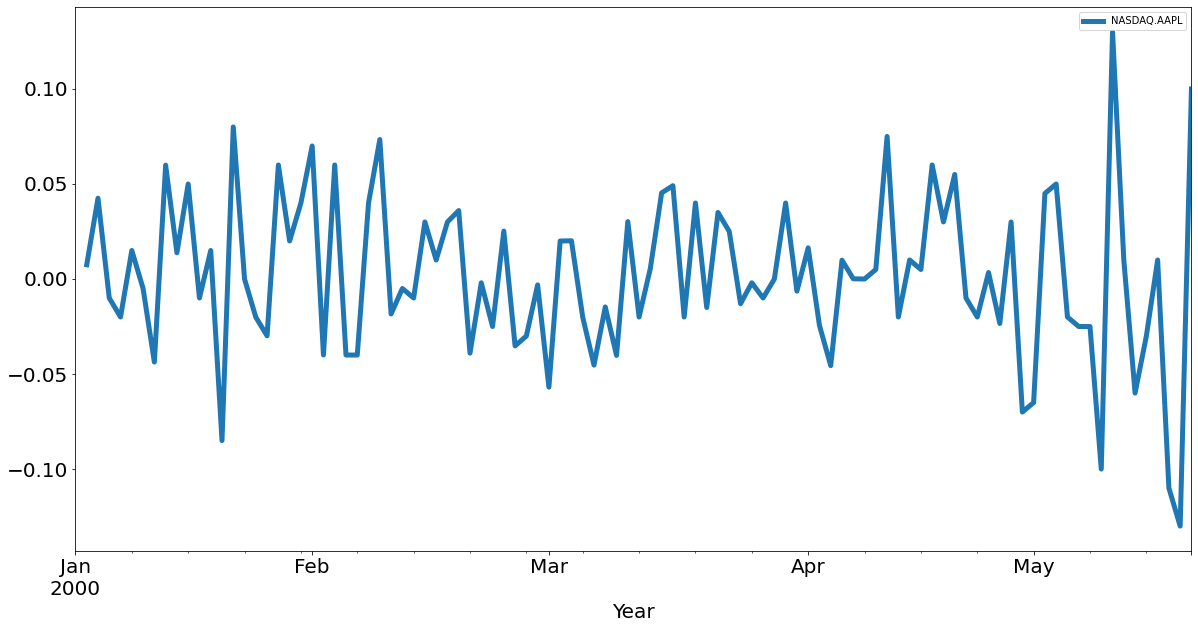

In [14]:
#Differencing Differencing is a decomposition process through which trend and seasonality are eliminated. Here, we usually take the difference of observation with particular instant with previous instant.

#First-order differencing
aapl.diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

Text(0.5, 1.0, 'AAPL Cumulative Returns')

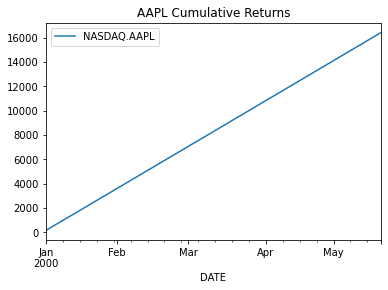

In [15]:
# Comulative Return
dr = aapl.cumsum()
dr.plot()
plt.title('AAPL Cumulative Returns')

Text(0.5, 1.0, 'AAPL Autocorrelation plot')

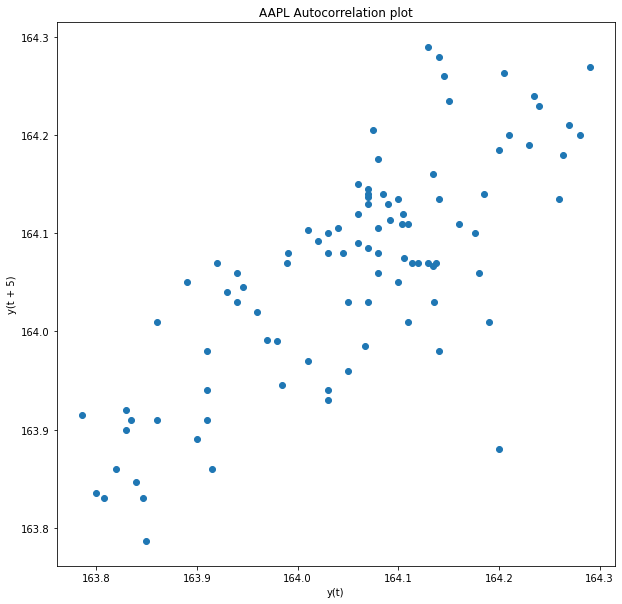

In [16]:
"""
Auto regression The approach of auto regression is basically an extended version of simple and multiple linear regressions. The only major difference is that the predictive relationship between the dependent and independent variables are assumed with in the previous values of same time series.
As a proper definition we can say that “A statistical model is said to be autoregressive if it predicts future values based on previous values.” Although there is no proved evidence that this has worked out most of the times in history, there is a major application of auto regression is still processed in financial markets and weather forecasting. 
The number of predictor variables is usually determined by the statistician which is nothing but the count of previous values that the asset had as a market or intrinsic measure. 
Mathematically, it is denoted as – AR(parameter) where parameter is the number of independent variables or the count of past values considered for forecasting. 
For example, AR (1) means that it is an autoregressive process where the immediate single past value in a defined time period is considered as independent variable. 
AR (2) means that it is an autoregressive process where the immediate two past values in a defined time period is considered as independent variables. AR (n) means that it is an autoregressive process where the immediate n past values in a defined time period is considered as independent variables. 
AR (0) is the easiest form of regression where the future value is considered as similar to the current value but this technically does not holds in growing or depreciating asset. 
We can define AR(4) mathematically as, Yt = B1 (Yt-1) + B2 (Yt-2) + B3 (Yt-3) + B4 (Yt-4) Where, Yt = Predicted value for next time period. Yt-1 = Recorded value for immediate past time period. Yt-2= Recorded value for immediate second past time period. Yt-1 = Recorded value for immediate third past time period. Yt-1 = Recorded value for immediate fourth past time period. B1 = Coefficient of auto regression for immediate past time period value. B2 = Coefficient of auto regression for immediate second past time period value. B3 = Coefficient of auto regression for immediate third past time period value. B4 = Coefficient of auto regression for immediate fourth past time period value.
"""
plt.figure(figsize=(10,10))
lag_plot(aapl[stockname], lag=5)
plt.title('AAPL Autocorrelation plot')

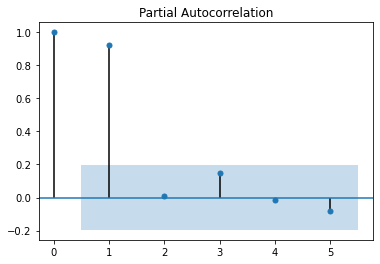

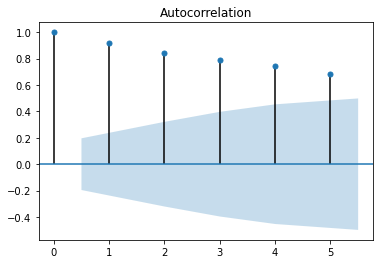

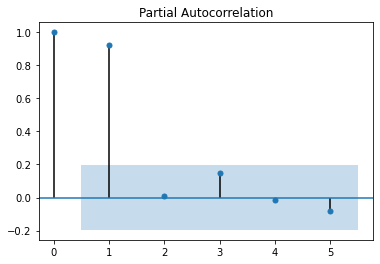

In [17]:
# import the plotting functions for act and pacf  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(aapl[stockname], lags=5)
plot_pacf(aapl[stockname], lags=5)

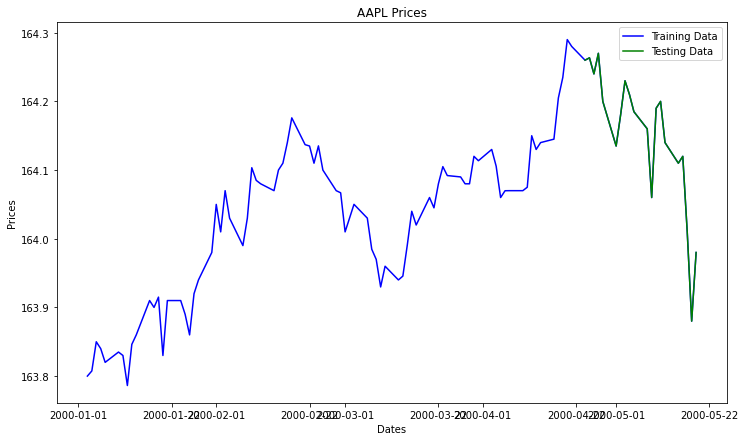

In [18]:
train_data, test_data = aapl[0:int(len(aapl)*0.8)], aapl[int(len(aapl)*0.8):]
plt.figure(figsize=(12,7))
plt.title('AAPL Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(aapl[stockname], 'blue', label='Training Data')
plt.plot(test_data[stockname], 'green', label='Testing Data')
plt.legend()

In [19]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

train_ar = train_data[stockname].values
test_ar = test_data[stockname].values

history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 0.005
Symmetric mean absolute percentage error: 0.062


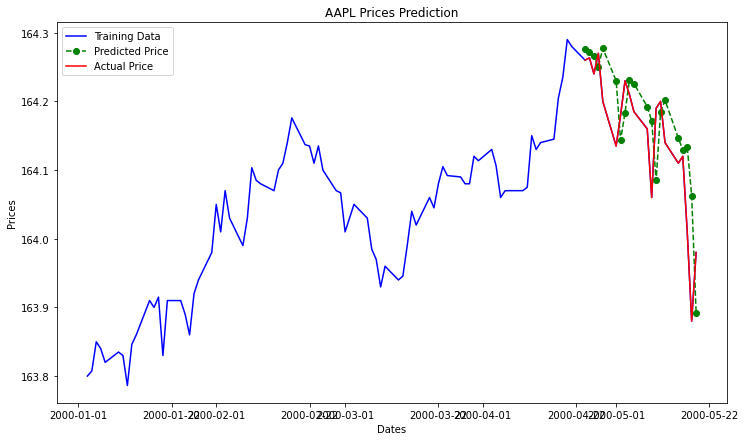

In [20]:
plt.figure(figsize=(12,7))
plt.plot(aapl[stockname],'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data[stockname], color='red', label='Actual Price')
plt.title('AAPL Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

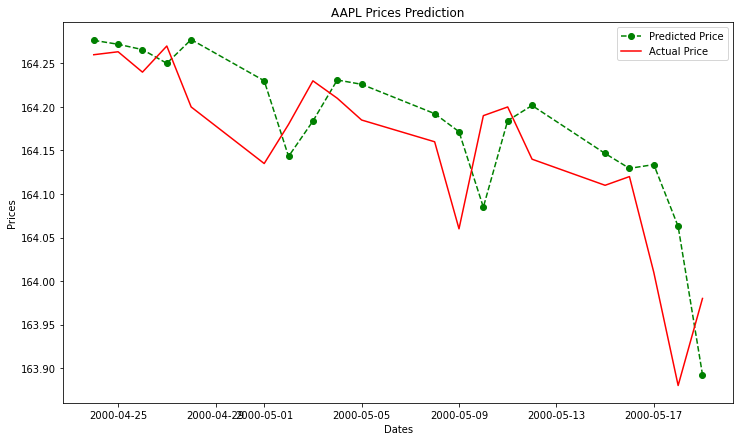

In [21]:
plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data[stockname], color='red', label='Actual Price')
plt.title('AAPL Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()


In [22]:
actual=pd.DataFrame()
actual=pd.DataFrame(test_ar,columns=["Actual"])
predicted=pd.DataFrame(list(predictions),columns=["Predicted"])
actual=actual.reset_index(drop=True)
predicted=predicted.reset_index(drop=True)
output=pd.concat([actual,predicted],axis=1)
print(output.head(10))

     Actual   Predicted
0  164.2600  164.276525
1  164.2634  164.272014
2  164.2400  164.265883
3  164.2700  164.250139
4  164.2000  164.277402
5  164.1350  164.230089
6  164.1800  164.143155
7  164.2300  164.183723
8  164.2100  164.230966
9  164.1850  164.226028
